In [1]:
#Script to run Gregory regressions for individual feedbacks that were calculated elsewhere. 

#APRP shortwave feedbacks, from MonthlyAPRP
#LW feedbacks from kernels, from MonthlyKernels


In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

In [3]:
pwd

'/home/russotto/projects/FeedbacksTRACMIP'

In [4]:
models_12 = ['AM2', 'CAM3', 'CAM4', 'CNRM-AM6-DIA-v2', 'ECHAM-6.1',
             'ECHAM-6.3', 'IPSL-CM5A', 'MIROC5', 'MPAS', 'MetUM-GA6-CTL',
             'MetUM-GA6-ENT', 'NorESM2']

#For LW cloud stuff
models_10 = ['AM2', 'CAM3', 'CAM4', 'ECHAM-6.1',
             'ECHAM-6.3', 'IPSL-CM5A', 'MIROC5', 
             'MPAS', 'MetUM-GA6-CTL', 'MetUM-GA6-ENT']

In [5]:
#Load climatological data for temperature regressions
ds_clim = xr.open_dataset('../nc_revised_20181130/master.nc').sel(exp='AquaControl')
ts_clim = ds_clim['ts']

In [6]:
print(ts_clim)
#Dimensions: model 13, time 12, lat 180, lon 180
#Will have to average annually

<xarray.DataArray 'ts' (model: 13, time: 12, lat: 180, lon: 180)>
[5054400 values with dtype=float64]
Coordinates:
    exp      <U11 'AquaControl'
  * model    (model) object 'AM2' 'CAM3' 'CAM4' ... 'MetUM-GA6-ENT' 'NorESM2'
  * time     (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2006-12-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0


In [10]:
#Still need the monthly temperature output--how did I deal with this in the past? 

#Something like this (from "GregoryTRACMIP.ipynb")
#forcing_test, feedback_test = GregoryNetRadiationTOA(xr.open_dataset('nc_from_xarray/monthly_zm_forGregory_rg2_a4_CAM3.nc'), ds_climo, 'CAM3')

#Still want to take zonal means of APRP results before doing Gregory regressions. 
#Have done the zonal means of temperature already. 

In [11]:
#Load the monthly zonal mean temperature for the model 
zm_ts = dict()
for model in models_12:
    zm_ts[model] = xr.open_dataset('nc_from_xarray/monthly_zm_forGregory_rg2_a4_'+model+'.nc')['ts']
    print(model)
    print(len(zm_ts[model].time))

AM2
480
CAM3
480
CAM4
480
CNRM-AM6-DIA-v2
480
ECHAM-6.1
540
ECHAM-6.3
480
IPSL-CM5A
360
MIROC5
480
MPAS
480
MetUM-GA6-CTL
480
MetUM-GA6-ENT
480
NorESM2
492


In [12]:
#Loop through the models and take zonal mean climatological temperature (not time mean yet)
zm_ts_clim = dict()
for model in models_12:
    zm_ts_clim[model] = ts_clim.mean(dim='lon').sel(model=model)

In [13]:
#Loop through the models and take zonal mean of APRP results. 
#Also assign time coordinates matching temperature stuff
zm_APRP = dict()
for model in models_12:
    print(model)
    ds_temp = xr.open_dataset('nc_from_xarray/APRP_monthly_results_a4_'+model+'.nc')
    zm_APRP[model] = ds_temp.mean(dim='lon')
    zm_APRP[model] = zm_APRP[model].assign_coords(time=zm_ts[model].time)
    #Time length mismatch for ECHAM-6.1--oh: had hard-coded CAM3

AM2


/usr/local/python/anaconda3/envs/pangeoJun2019/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM3
CAM4
CNRM-AM6-DIA-v2
ECHAM-6.1
ECHAM-6.3
IPSL-CM5A
MIROC5
MPAS
MetUM-GA6-CTL
MetUM-GA6-ENT
NorESM2


In [14]:
#Test printing for dimensions
print(zm_ts['CAM4'])
print(zm_ts_clim['CAM4'])
print(zm_APRP['CAM4'])

<xarray.DataArray 'ts' (time: 480, lat: 180)>
array([[273.74236 , 274.023773, 274.328748, ..., 277.381943, 277.389094,
        277.471495],
       [275.05118 , 275.323766, 275.621026, ..., 276.391368, 276.402738,
        276.470611],
       [275.160077, 275.446966, 275.753245, ..., 275.246814, 275.269128,
        275.351835],
       ...,
       [275.662582, 275.791885, 275.997043, ..., 288.149216, 288.073756,
        288.050627],
       [276.693896, 276.836325, 277.049511, ..., 287.208239, 287.190861,
        287.21159 ],
       [278.654892, 278.825943, 279.051772, ..., 285.937036, 285.952593,
        286.011318]])
Coordinates:
  * time     (time) object 0046-01-16 12:00:00 ... 0085-12-16 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
<xarray.DataArray 'ts' (time: 12, lat: 180)>
array([[273.731261, 273.963225, 274.238919, ..., 277.744357, 277.767069,
        277.844655],
       [274.945676, 275.190328, 275.479251, ..., 276.27251 , 276.294315,


In [15]:
#Function to calculate Gregory regressions for APRP results 
#ts_monthly: DataArray containing zonal mean temperature in each month for the model
#ts_clim: DataArray containing monthly climatologies of zonal mean temperature  
#ds_monthly_APRP: Dataset containing zonal mean APRP results in individual months
#
#return: 6 variables (rapid adjustment & feedback for each of the 3 APRP outputs)
#Acutally it would be good if it could return an xarray dataset that I could concatenate along the models. 
def GregoryAPRP(ts_monthly, ts_clim, ds_monthly_APRP):
    
    #Duplicate the climatology to match the length of the monthly output
    numYears = int(len(ts_monthly.time)/len(ts_clim.time))
    ts_clim_raw = ts_clim.data
    ts_clim_dupe = np.tile(ts_clim_raw, (numYears,1))
    
    #Calculate the temperature anomaly by subtracting these variables; this will take care of seasonal cycle
    ts_anom = ts_monthly - ts_clim_dupe
    
    #Calculate annual means of the temperature anomalies and APRP results 
    ts_anom_ann = ts_anom.resample(time='1Y').mean(dim='time')
    APRP_cloud_ann = ds_monthly_APRP['cloud'].resample(time='1Y').mean(dim='time')
    APRP_noncloud_ann = ds_monthly_APRP['noncloud'].resample(time='1Y').mean(dim='time')
    APRP_surface_ann = ds_monthly_APRP['surface'].resample(time='1Y').mean(dim='time')
    
    #Print some output and make some plots to see how well the seasonal cycle is taken out
    #print('years: ' + str(numYears)) #e.g. 40 for CAM3
#     plt.figure()
#     plt.plot(ts_anom_ann.isel(lat=40), 'k')
#     plt.plot(APRP_cloud_ann.isel(lat=40), 'r')
#     plt.plot(APRP_noncloud_ann.isel(lat=40), 'g')
    plt.figure(figsize=(14,6))
    #plt.pcolor(APRP_surface_ann) #hovmoller for test
    plt.subplot(1,3,1)
    plt.pcolor(ds_monthly_APRP['cloud'])
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.pcolor(ds_monthly_APRP['noncloud'])
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.pcolor(ds_monthly_APRP['surface'])
    plt.colorbar()
    plt.xlabel('lat')
    plt.ylabel('time')
    plt.suptitle(model)
    
    
    #Regress the annual means against each other to get adjustment and feedback for each effect
    
    #Preallocate arrays for the zonal mean rapid adjustments and feedbacks
    numLats = len(ts_monthly.lat)
    adj_cloud = np.zeros(numLats)
    fb_cloud = np.zeros(numLats)
    adj_noncloud = np.zeros(numLats)
    fb_noncloud = np.zeros(numLats)
    adj_surface = np.zeros(numLats)
    fb_surface = np.zeros(numLats)
    
    #Run polyfit for each forcing/feedback at each latitude
    for i in np.arange(numLats):
        p1 = np.polyfit(ts_anom_ann.isel(lat=i).data, APRP_cloud_ann.isel(lat=i).data, 1)
        adj_cloud[i] = p1[1] #intercept
        fb_cloud[i] = p1[0] #slope
        
        p2 = np.polyfit(ts_anom_ann.isel(lat=i).data, APRP_noncloud_ann.isel(lat=i).data, 1)
        adj_noncloud[i] = p2[1] 
        fb_noncloud[i] = p2[0] 
        
        p3 = np.polyfit(ts_anom_ann.isel(lat=i).data, APRP_surface_ann.isel(lat=i).data, 1)
        adj_surface[i] = p3[1]
        fb_surface[i] = p3[0]
    
    #Concatenate back into an XArray Dataset and return
    da_adj_cloud = xr.DataArray(adj_cloud, coords=[ts_monthly.lat], dims=['lat'], name='adj_cloud')
    da_fb_cloud = xr.DataArray(fb_cloud, coords=[ts_monthly.lat], dims=['lat'], name='fb_cloud')
    da_adj_noncloud = xr.DataArray(adj_noncloud, coords=[ts_monthly.lat], dims=['lat'], name='adj_noncloud')
    da_fb_noncloud = xr.DataArray(fb_noncloud, coords=[ts_monthly.lat], dims=['lat'], name='fb_noncloud')
    da_adj_surface = xr.DataArray(adj_surface, coords=[ts_monthly.lat], dims=['lat'], name='adj_surface')
    da_fb_surface = xr.DataArray(fb_surface, coords=[ts_monthly.lat], dims=['lat'], name='fb_surface')
    
    ds_Greg_APRP = xr.merge([da_adj_cloud, da_fb_cloud, da_adj_noncloud, da_fb_noncloud, da_adj_surface, da_fb_surface])
    return ds_Greg_APRP

In [16]:
print(pd.Index(models_12))

Index(['AM2', 'CAM3', 'CAM4', 'CNRM-AM6-DIA-v2', 'ECHAM-6.1', 'ECHAM-6.3',
       'IPSL-CM5A', 'MIROC5', 'MPAS', 'MetUM-GA6-CTL', 'MetUM-GA6-ENT',
       'NorESM2'],
      dtype='object')


AM2
CAM3
CAM4
CNRM-AM6-DIA-v2
ECHAM-6.1
ECHAM-6.3
IPSL-CM5A
MIROC5
MPAS
MetUM-GA6-CTL
MetUM-GA6-ENT
NorESM2


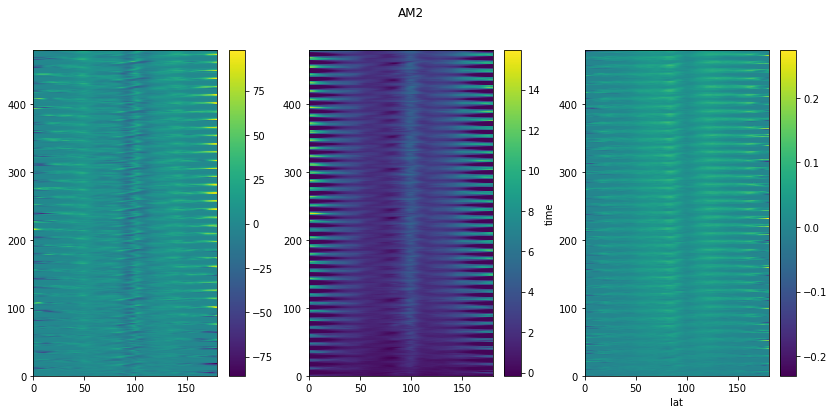

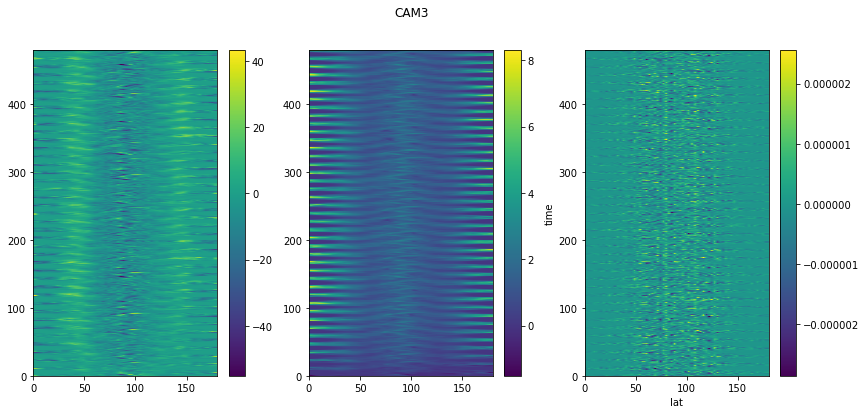

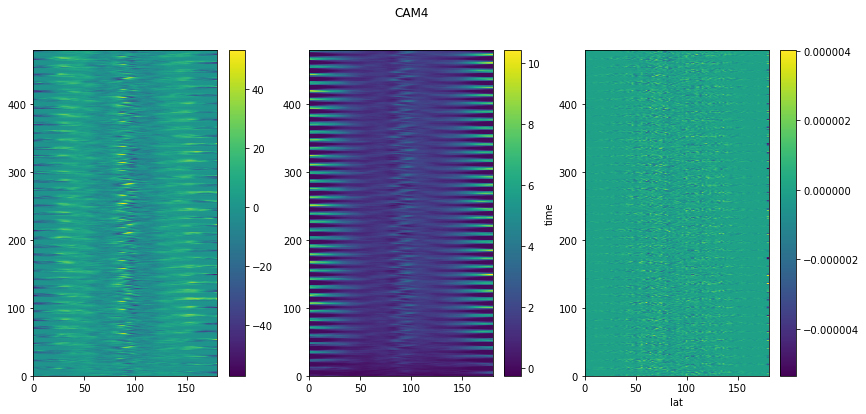

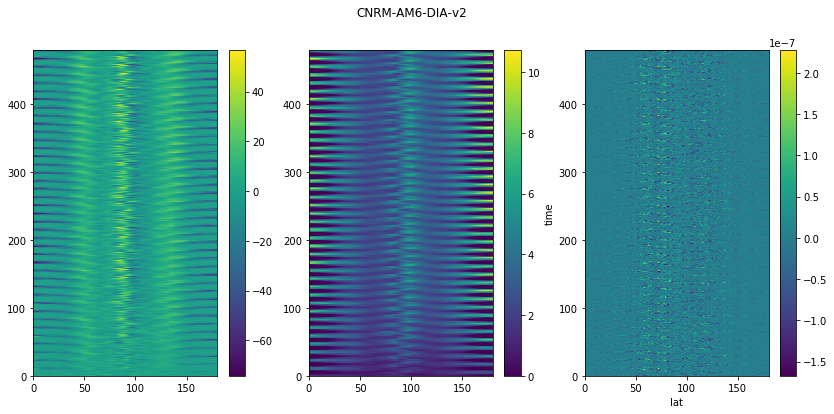

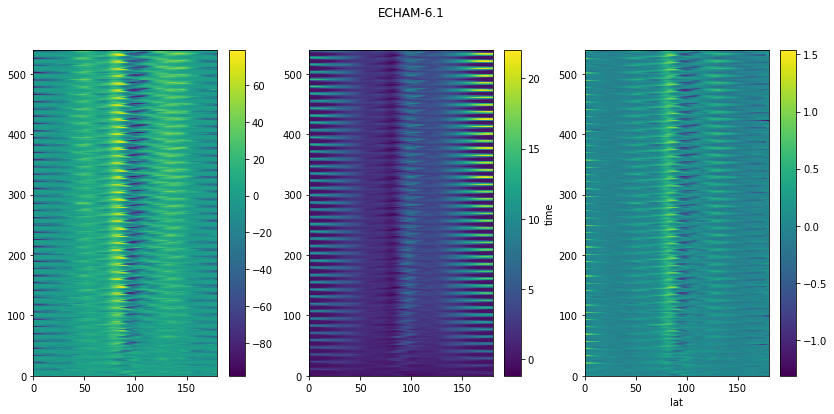

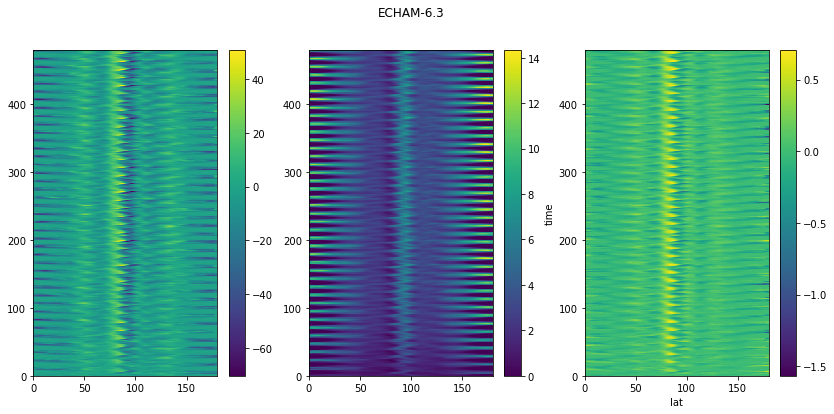

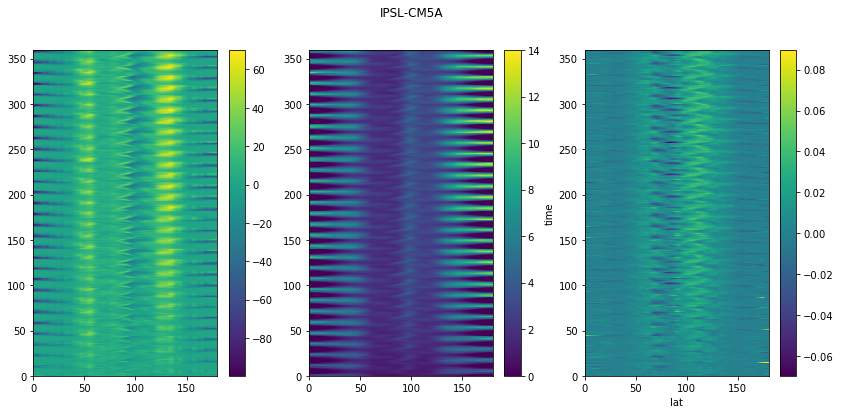

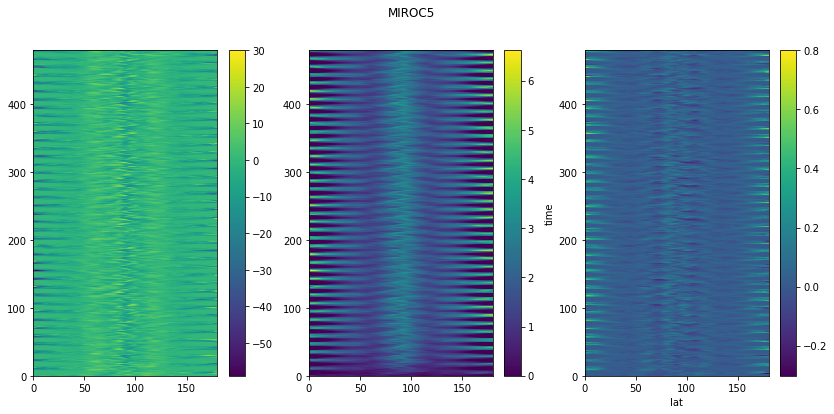

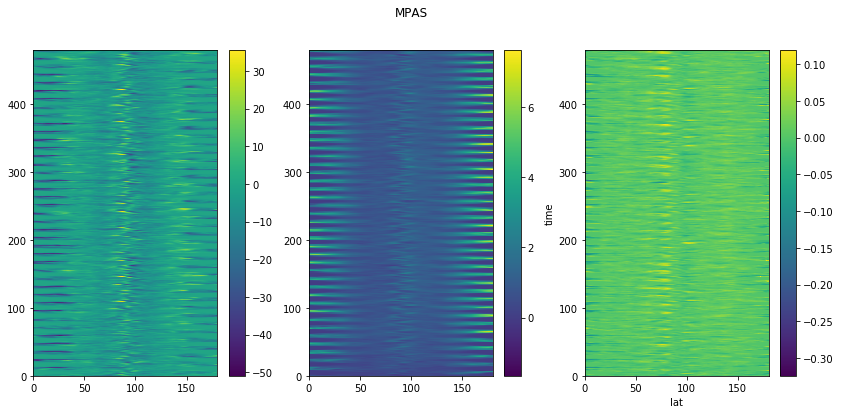

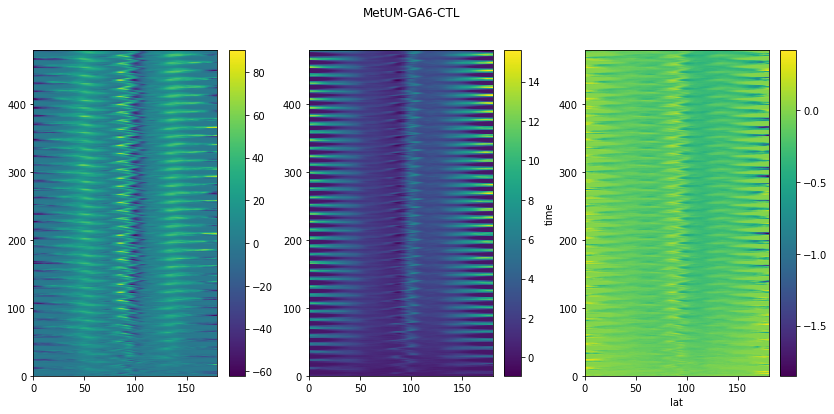

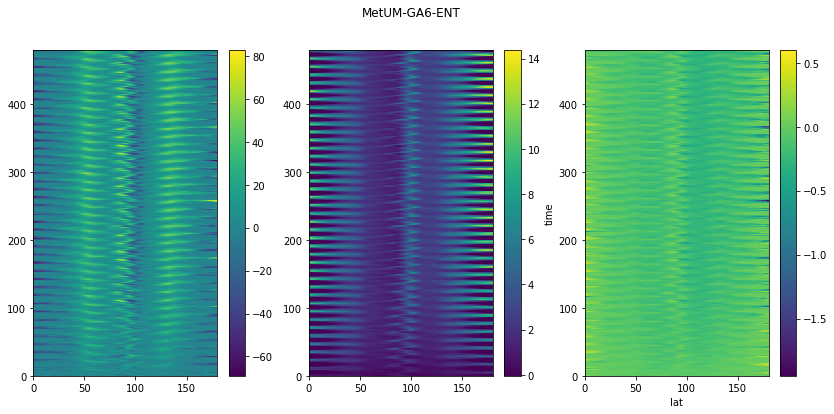

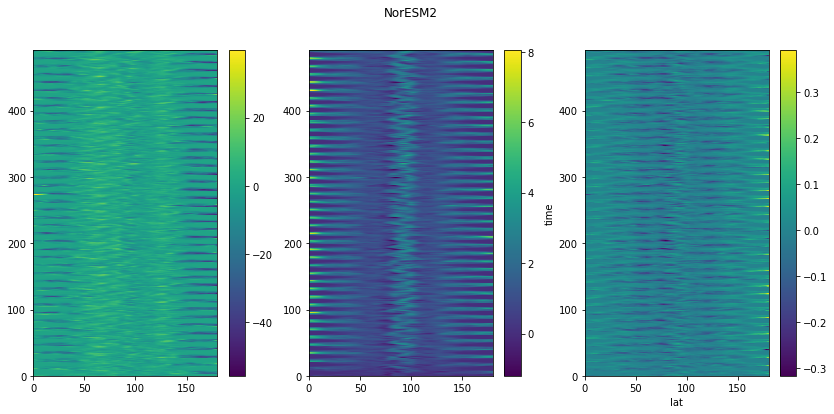

In [17]:
#Loop through the models and run the regresions

return_dict = dict()
for model in models_12:
    print(model)
    return_dict[model] = GregoryAPRP(zm_ts[model], zm_ts_clim[model], zm_APRP[model])
    

In [18]:
#Concatenate returned Datasets along model dimension

models_index = pd.Index(models_12) #Pandas Index object for the new model dimension
ds_Gregory_APRP = xr.concat(return_dict.values(), dim=models_index)
ds_Gregory_APRP = ds_Gregory_APRP.rename({'concat_dim': 'model'})

In [19]:

print(ds_Gregory_APRP)

<xarray.Dataset>
Dimensions:       (lat: 180, model: 12)
Coordinates:
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * model         (model) object 'AM2' 'CAM3' ... 'MetUM-GA6-ENT' 'NorESM2'
Data variables:
    adj_cloud     (model, lat) float64 -4.09 -3.993 -3.679 ... -2.332 -2.712
    fb_cloud      (model, lat) float64 0.2355 0.2363 0.2158 ... -1.686 -1.609
    adj_noncloud  (model, lat) float64 0.6369 0.7066 0.6912 ... 0.3877 0.3931
    fb_noncloud   (model, lat) float64 0.4249 0.4234 0.4218 ... 0.3089 0.3038
    adj_surface   (model, lat) float64 -0.004118 -0.003351 ... 0.01495 0.02083
    fb_surface    (model, lat) float64 0.0004518 0.0003993 ... 0.01035 0.008398


In [21]:
#Save the results to a NetCDF file
ds_Gregory_APRP.to_netcdf('nc_from_xarray/GregoryAPRP_a4.nc')

In [ ]:
#From the plots: why is surface albedo term significant at all in some models?
#Analyze plots in a different script

In [ ]:
#Now see a strog seasonal cycle for all the terms, not just one. 
#this doesn't seem to be an issue of one model being hard-coded. 

In [22]:
#7-23-19: after fix of clt units, results are much better behaved. Surface albedo term always small, 
#there is still a seasonal cycle but annual averaging will take care of it. 

In [9]:


#####   LONGWAVE FEEDBACKS   #####

#  (from kernels)



In [10]:
#Loop through the models, load and take zonal mean of kernel results. 
#Also assign time coordinates matching temperature stuff
zm_dLW_ta = dict()
for model in models_12:
    print(model)
    ds_temp = xr.open_dataset('nc_from_xarray/dLW_ta_rg_'+model+'.nc')
    zm_dLW_ta[model] = ds_temp.mean(dim='lon')
    zm_dLW_ta[model] = zm_dLW_ta[model].assign_coords(time=zm_ts[model].time)

AM2
CAM3
CAM4
CNRM-AM6-DIA-v2
ECHAM-6.1
ECHAM-6.3
IPSL-CM5A
MIROC5
MPAS
MetUM-GA6-CTL
MetUM-GA6-ENT
NorESM2


In [11]:
#Test printing for dimensions
print(zm_dLW_ta['CAM4']) #lat: 180, time: 480

<xarray.Dataset>
Dimensions:  (lat: 180, time: 480)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) object 0046-01-16 12:00:00 ... 0085-12-16 12:00:00
Data variables:
    dLW      (time, lat) float64 1.423 4.269 5.317 5.194 ... 16.66 13.16 4.387


In [12]:
#Need a function analogous to the one above for kernel results. 
#Only one function which will be run multiple times for the different kernel outputs
#(since there is only one output in W/m^2, not a package of 3 like for APRP. )

In [13]:
#ts_monthly: DataArray containing zonal mean temperature in each month for the model
#ts_clim: DataArray containing monthly climatologies of zonal mean temperature  
#ds_monthly_kernel: Dataset containing zonal mean kernel results in individual months
def GregoryKernel(ts_monthly, ts_clim, ds_monthly_kernel):
    
    #Duplicate the climatology to match the length of the monthly output
    numYears = int(len(ts_monthly.time)/len(ts_clim.time))
    ts_clim_raw = ts_clim.data
    ts_clim_dupe = np.tile(ts_clim_raw, (numYears,1))
    
    #Calculate the temperature anomaly by subtracting these variables; this will take care of seasonal cycle
    ts_anom = ts_monthly - ts_clim_dupe
    
    #Calculate annual means of the temperature anomalies and kernel results 
    ts_anom_ann = ts_anom.resample(time='1Y').mean(dim='time')
    kernel_ann = ds_monthly_kernel['dLW'].resample(time='1Y').mean(dim='time')
    
    #Hovmoller plot for debugging
    plt.figure(figsize=(5,6))
    plt.pcolor(ds_monthly_kernel['dLW'])
    plt.colorbar()
    plt.xlabel('latitude')
    plt.ylabel('month')
    plt.title(model) #not passed in but will work if "model" is defined in loop where this is run
    
    
    #Regress the annual means against each other to get rapid adjustment and feedback
    
    #Preallocate arrays for the zonal mean rapid adjustments and feedbacks
    numLats = len(ts_monthly.lat)
    adj = np.zeros(numLats)
    fb = np.zeros(numLats)
    
    #Run polyfit at each latitude
    for i in np.arange(numLats):
        p1 = np.polyfit(ts_anom_ann.isel(lat=i).data, kernel_ann.isel(lat=i).data, 1)
        adj[i] = p1[1] #intercept
        fb[i] = p1[0] #slope
    
    #Concatenate back into an XArray Dataset and return
    da_adj = xr.DataArray(adj, coords=[ts_monthly.lat], dims=['lat'], name='adj')
    da_fb = xr.DataArray(fb, coords=[ts_monthly.lat], dims=['lat'], name='fb')
    
    ds_Greg = xr.merge([da_adj, da_fb])
    return ds_Greg
    

AM2
CAM3
CAM4
CNRM-AM6-DIA-v2
ECHAM-6.1
ECHAM-6.3
IPSL-CM5A
MIROC5
MPAS
MetUM-GA6-CTL
MetUM-GA6-ENT
NorESM2


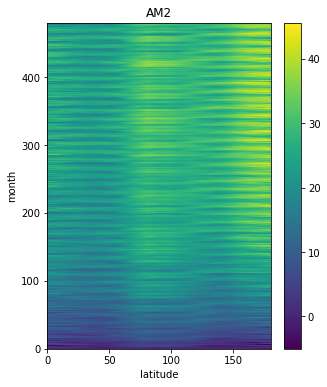

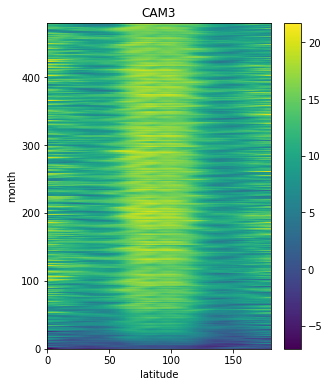

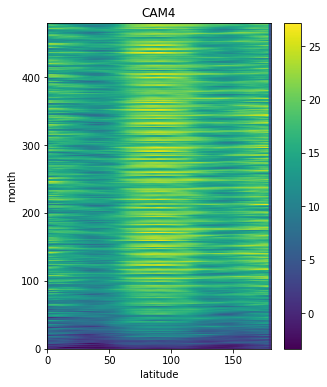

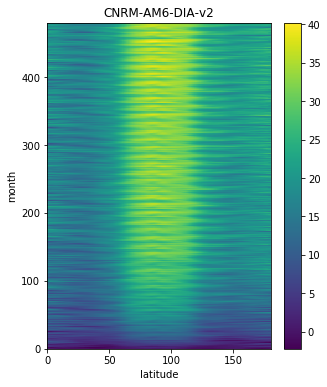

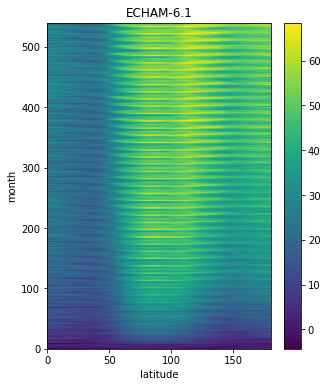

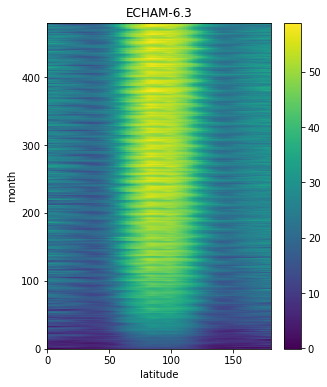

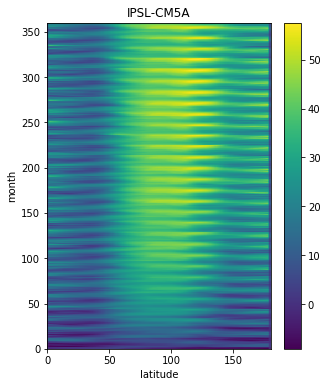

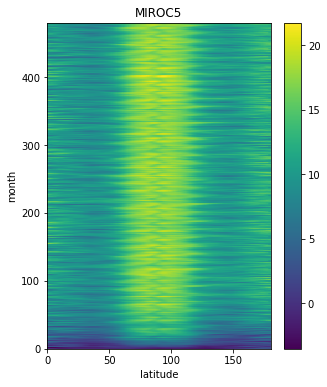

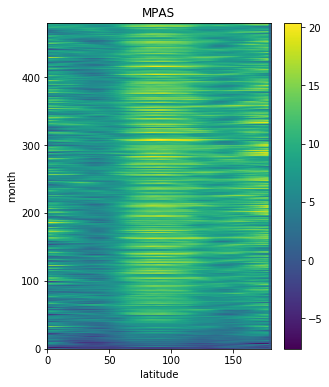

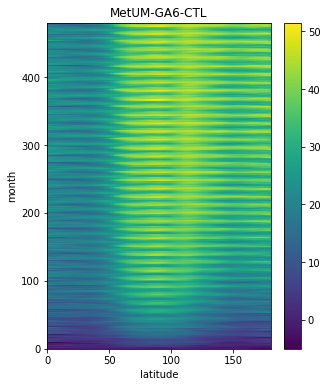

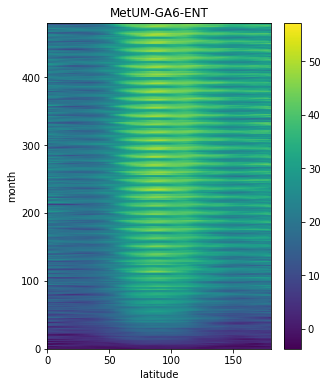

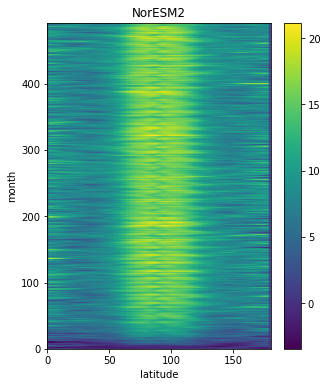

In [14]:
#Loop through the models and run the regressions
return_dict_dLW_ta = dict()
for model in models_12:
    print(model)
    return_dict_dLW_ta[model] = GregoryKernel(zm_ts[model], zm_ts_clim[model], zm_dLW_ta[model])

In [41]:
#Looks OK. 

In [15]:
#Concatenate returned Datasets along model dimension

models_index = pd.Index(models_12) #Pandas Index object for the new model dimension
ds_Gregory_dLW_ta = xr.concat(return_dict_dLW_ta.values(), dim=models_index)
ds_Gregory_dLW_ta = ds_Gregory_dLW_ta.rename({'concat_dim': 'model'})

In [16]:
#Save the results to a NetCDF file
ds_Gregory_dLW_ta.to_netcdf('nc_from_xarray/Gregory_kernel_ta_a4.nc')

In [34]:
#Run also for the water vapor and surface temperature kernels, based on 
#calculations done in MonthlyKernels.ipynb

In [ ]:
#Water vapor

In [19]:
zm_dLW_wv = dict()
for model in models_12:
    print(model)
    ds_temp = xr.open_dataset('nc_from_xarray/dLW_wv_rg_'+model+'.nc')
    zm_dLW_wv[model] = ds_temp.mean(dim='lon')
    zm_dLW_wv[model] = zm_dLW_wv[model].assign_coords(time=zm_ts[model].time)

AM2
CAM3
CAM4
CNRM-AM6-DIA-v2
ECHAM-6.1
ECHAM-6.3
IPSL-CM5A
MIROC5
MPAS
MetUM-GA6-CTL
MetUM-GA6-ENT
NorESM2


AM2
CAM3
CAM4
CNRM-AM6-DIA-v2
ECHAM-6.1
ECHAM-6.3
IPSL-CM5A
MIROC5
MPAS
MetUM-GA6-CTL
MetUM-GA6-ENT
NorESM2


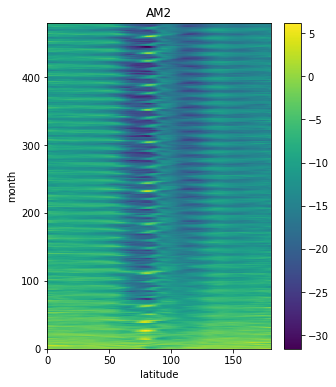

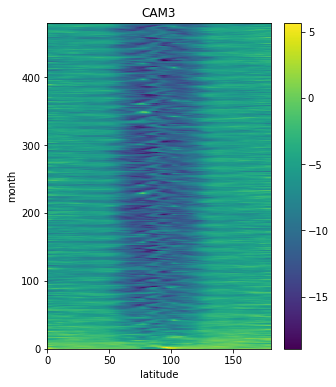

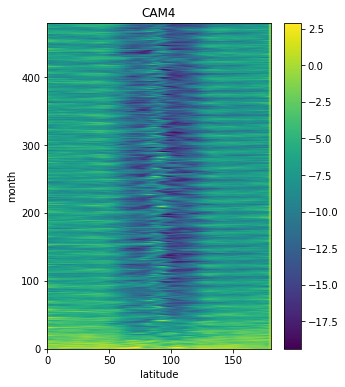

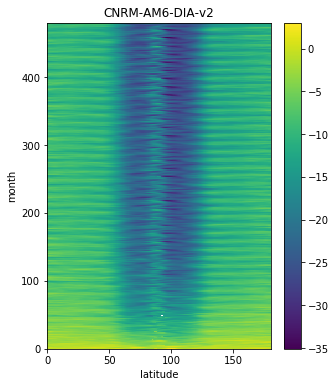

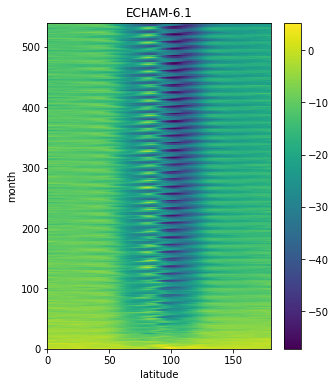

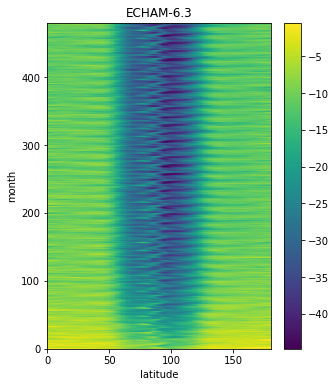

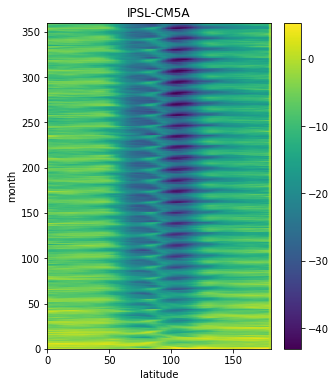

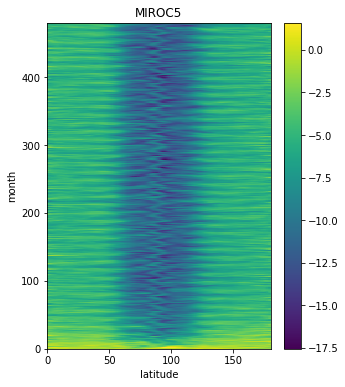

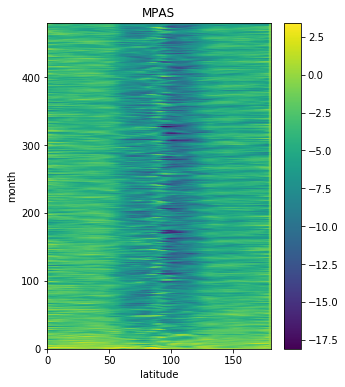

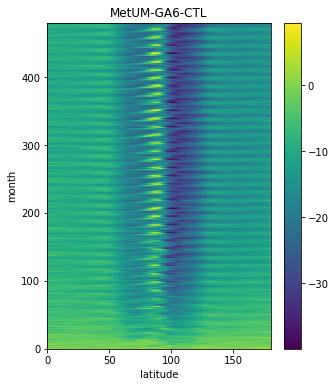

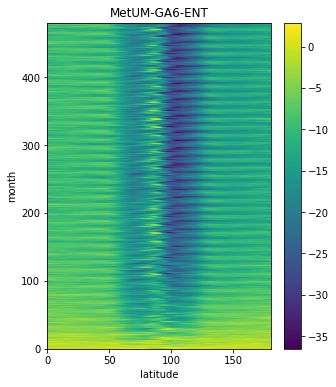

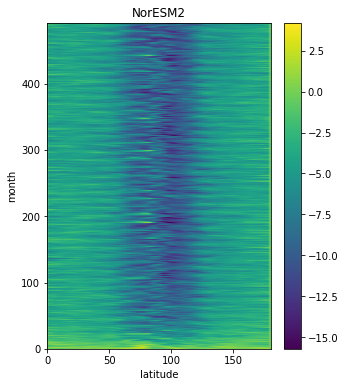

In [20]:

return_dict_dLW_wv = dict()
for model in models_12:
    print(model)
    return_dict_dLW_wv[model] = GregoryKernel(zm_ts[model], zm_ts_clim[model], zm_dLW_wv[model])

In [21]:
models_index = pd.Index(models_12) #Pandas Index object for the new model dimension
ds_Gregory_dLW_wv = xr.concat(return_dict_dLW_wv.values(), dim=models_index)
ds_Gregory_dLW_wv = ds_Gregory_dLW_wv.rename({'concat_dim': 'model'})
ds_Gregory_dLW_wv.to_netcdf('nc_from_xarray/Gregory_kernel_wv_a4.nc')

In [23]:
#Finally for the surface temperature

zm_dLW_ts = dict()
for model in models_12:
    print(model)
    ds_temp = xr.open_dataset('nc_from_xarray/dLW_ts_rg_'+model+'.nc')
    zm_dLW_ts[model] = ds_temp.mean(dim='lon')
    zm_dLW_ts[model] = zm_dLW_ts[model].assign_coords(time=zm_ts[model].time)

AM2


/usr/local/python/anaconda3/envs/pangeoJun2019/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CAM3
CAM4
CNRM-AM6-DIA-v2


/usr/local/python/anaconda3/envs/pangeoJun2019/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


ECHAM-6.1
ECHAM-6.3
IPSL-CM5A
MIROC5
MPAS
MetUM-GA6-CTL
MetUM-GA6-ENT
NorESM2


AM2
CAM3
CAM4
CNRM-AM6-DIA-v2
ECHAM-6.1
ECHAM-6.3
IPSL-CM5A
MIROC5
MPAS
MetUM-GA6-CTL
MetUM-GA6-ENT
NorESM2


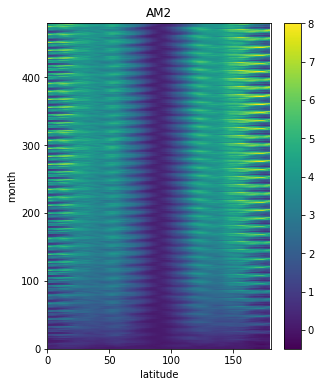

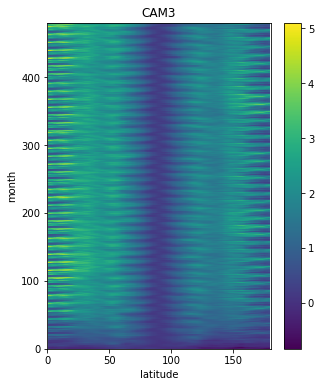

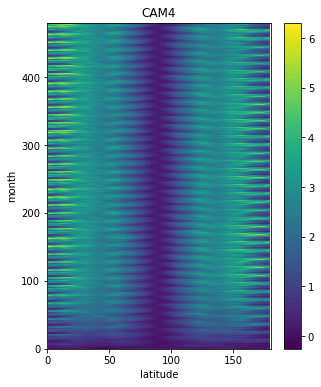

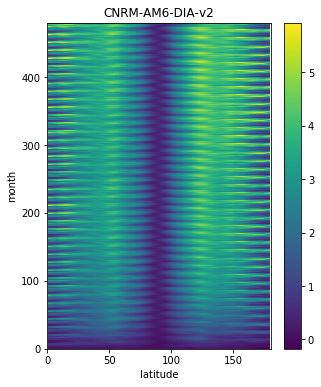

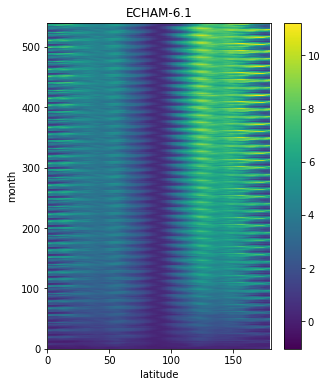

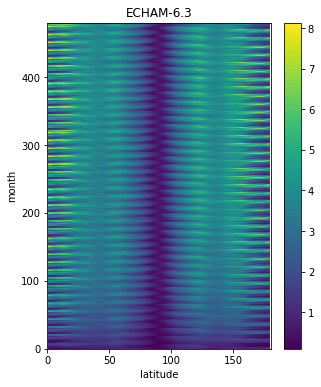

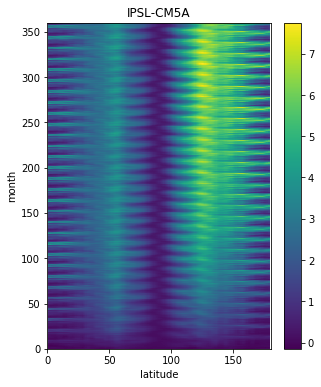

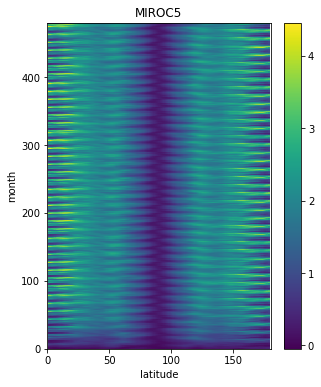

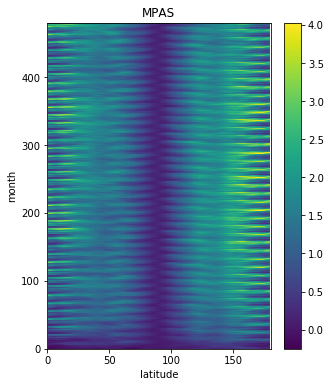

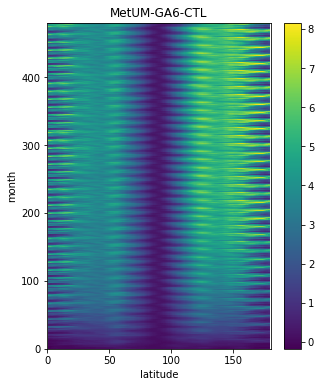

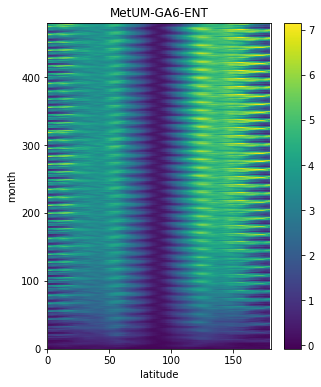

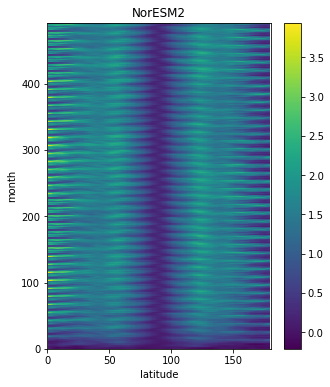

In [24]:
return_dict_dLW_ts = dict()
for model in models_12:
    print(model)
    return_dict_dLW_ts[model] = GregoryKernel(zm_ts[model], zm_ts_clim[model], zm_dLW_ts[model])

In [27]:
ds_Gregory_dLW_ts = xr.concat(return_dict_dLW_ts.values(), dim=pd.Index(models_12))
ds_Gregory_dLW_ts = ds_Gregory_dLW_ts.rename({'concat_dim': 'model'})
ds_Gregory_dLW_ts.to_netcdf('nc_from_xarray/Gregory_kernel_ts_a4.nc')

In [ ]:
#Kernel has opposite sign convention from APRP so keep this in mind. 
#Need to flip sign of rapid adjustments and feedbacks. 

In [10]:


#####   LONGWAVE CLOUD RADIATIVE EFFECTS AND FEEDBACKS   #####

#(from ApplyKernels_CloudLW and MonthlyKernels_CloudLW)

In [15]:
#Loop through the models, load zonal mean of uncorrected and corrected
#monthly cloud radiative effect changes. 
#Also assign time coordinates matching temperature stuff
zm_dLWCRE_raw = dict()
zm_dLWCRE_co = dict()
for model in models_10:
    print(model)
    zm_dLWCRE_raw[model] = xr.open_dataarray('nc_from_xarray/dLWCRE_raw_monthly_'+model+'.nc')
    zm_dLWCRE_co[model] = xr.open_dataarray('nc_from_xarray/dLWCRE_co_monthly_'+model+'.nc')
    zm_dLWCRE_raw[model] = zm_dLWCRE_raw[model].assign_coords(time=zm_ts[model].time)
    zm_dLWCRE_co[model] = zm_dLWCRE_co[model].assign_coords(time=zm_ts[model].time)
    #print(zm_dLWCRE_raw[model])
    #print(zm_dLWCRE_co[model])

AM2
CAM3
CAM4
ECHAM-6.1
ECHAM-6.3
IPSL-CM5A
MIROC5
MPAS
MetUM-GA6-CTL
MetUM-GA6-ENT


In [16]:
#Function to calculate the Gregory regression (similar to that for the kernel)
#(inputting DataArray instead of Dataset this time)
def GregoryLWCRE(ts_monthly, ts_clim, da_monthly_dLWCRE):
    
    #Duplicate the climatology to match the length of the monthly output
    numYears = int(len(ts_monthly.time)/len(ts_clim.time))
    ts_clim_raw = ts_clim.data
    ts_clim_dupe = np.tile(ts_clim_raw, (numYears,1))
    
    #Calculate the temperature anomaly by subtracting these variables; this will take care of seasonal cycle
    ts_anom = ts_monthly - ts_clim_dupe
    
    #Calculate annual means of the temperature anomalies and kernel results 
    ts_anom_ann = ts_anom.resample(time='1Y').mean(dim='time')
    dLWCRE_ann = da_monthly_dLWCRE.resample(time='1Y').mean(dim='time')
    
    #Hovmoller plot for debugging (actually did this in previous script for these quantities)
    #plt.figure(figsize=(5,6))
    #plt.pcolor(ds_monthly_kernel['dLW'])
    #plt.colorbar()
    #plt.xlabel('latitude')
    #plt.ylabel('month')
    #plt.title(model) #not passed in but will work if "model" is defined in loop where this is run
    
    
    #Regress the annual means against each other to get rapid adjustment and feedback
    
    #Preallocate arrays for the zonal mean rapid adjustments and feedbacks
    numLats = len(ts_monthly.lat)
    adj = np.zeros(numLats)
    fb = np.zeros(numLats)
    
    #Run polyfit at each latitude
    for i in np.arange(numLats):
        p1 = np.polyfit(ts_anom_ann.isel(lat=i).data, dLWCRE_ann.isel(lat=i).data, 1)
        adj[i] = p1[1] #intercept
        fb[i] = p1[0] #slope
    
    #Concatenate back into an XArray Dataset and return
    da_adj = xr.DataArray(adj, coords=[ts_monthly.lat], dims=['lat'], name='adj')
    da_fb = xr.DataArray(fb, coords=[ts_monthly.lat], dims=['lat'], name='fb')
    
    ds_Greg = xr.merge([da_adj, da_fb])
    return ds_Greg
    

In [18]:
#Loop through the models and run the regressions
return_dict_dLWCRE_raw = dict()
return_dict_dLWCRE_co = dict()
for model in models_10:
    print(model)
    return_dict_dLWCRE_raw[model] = GregoryLWCRE(zm_ts[model], zm_ts_clim[model], zm_dLWCRE_raw[model])
    return_dict_dLWCRE_co[model] = GregoryLWCRE(zm_ts[model], zm_ts_clim[model], zm_dLWCRE_co[model])

AM2
CAM3
CAM4
ECHAM-6.1
ECHAM-6.3
IPSL-CM5A
MIROC5
MPAS
MetUM-GA6-CTL
MetUM-GA6-ENT


In [21]:
#Concatenate the results into a single XArray Dataset and save to NetCDF (raw)
ds_Gregory_dLWCRE_raw = xr.concat(return_dict_dLWCRE_raw.values(), dim=pd.Index(models_10))
ds_Gregory_dLWCRE_raw = ds_Gregory_dLWCRE_raw.rename({'concat_dim': 'model'})
ds_Gregory_dLWCRE_raw.to_netcdf('nc_from_xarray/Gregory_dLWCRE_raw_a4.nc')

In [22]:
#Same for corrected
ds_Gregory_dLWCRE_co = xr.concat(return_dict_dLWCRE_co.values(), dim=pd.Index(models_10))
ds_Gregory_dLWCRE_co = ds_Gregory_dLWCRE_co.rename({'concat_dim': 'model'})
ds_Gregory_dLWCRE_co.to_netcdf('nc_from_xarray/Gregory_dLWCRE_co_a4.nc')

In [1]:



#####   PLANCK AND LAPSE RATE FEEDBACKS   #####




In [ ]:
#Have lapse rate radiation change already; 
#Planck feedback is the difference between total temperature effect and lapse rate effect.

#First run cells up to defining zonal mean temperature and the Gregory kernel function definition

In [14]:
#Load radiation changes (from MonthlyKernels) into dict and take zonal mean
zm_dLW_lr = dict()
for model in models_12:
    print(model)
    ds_temp = xr.open_dataset('nc_from_xarray/dLW_lr_rg_'+model+'.nc')
    zm_dLW_lr[model] = ds_temp.mean(dim='lon')
    zm_dLW_lr[model] = zm_dLW_lr[model].assign_coords(time=zm_ts[model].time)

AM2
CAM3
CAM4
CNRM-AM6-DIA-v2
ECHAM-6.1
ECHAM-6.3
IPSL-CM5A
MIROC5
MPAS
MetUM-GA6-CTL
MetUM-GA6-ENT
NorESM2


AM2
CAM3
CAM4
CNRM-AM6-DIA-v2
ECHAM-6.1
ECHAM-6.3
IPSL-CM5A
MIROC5
MPAS
MetUM-GA6-CTL
MetUM-GA6-ENT
NorESM2


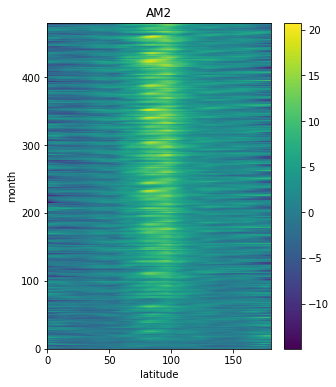

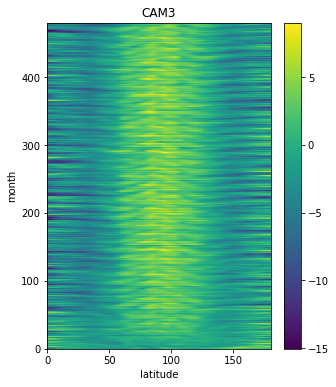

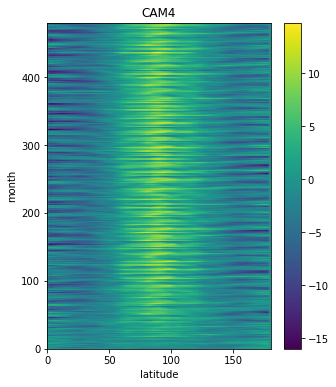

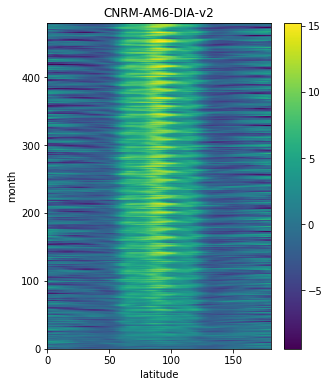

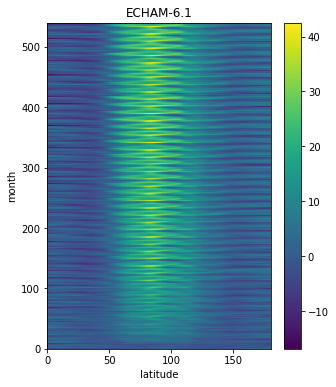

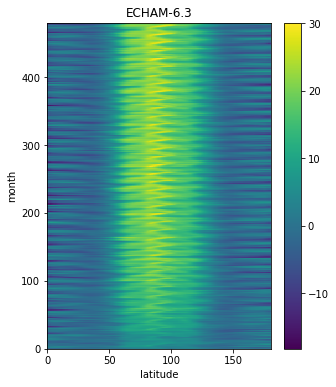

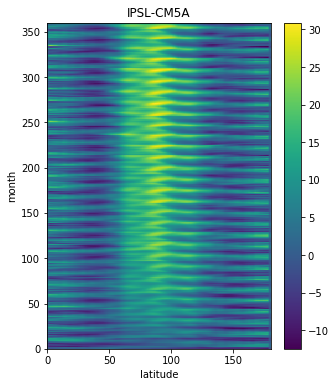

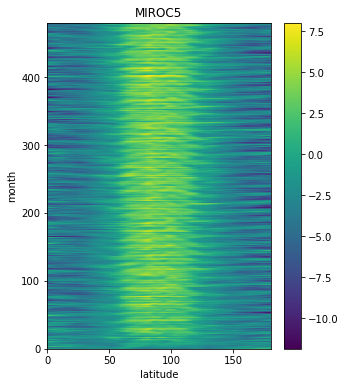

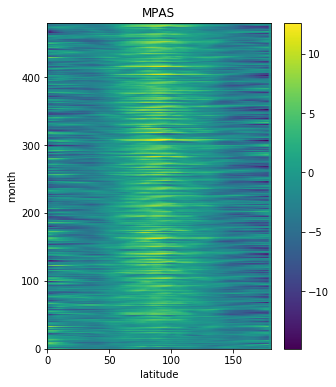

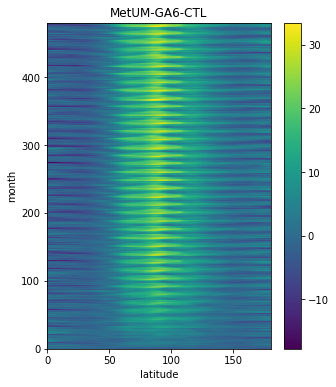

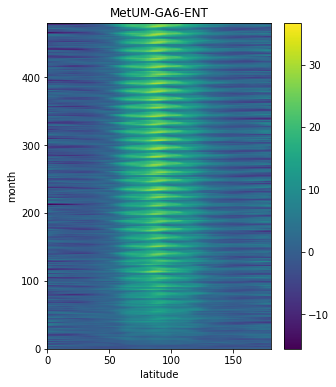

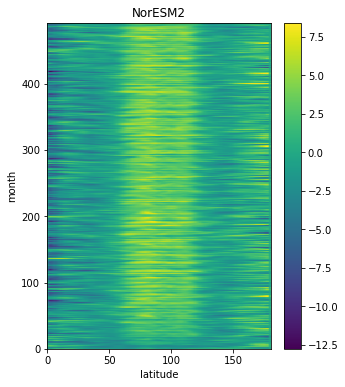

In [15]:
#Run the Gregory regressions on the lapse rate kernel results
return_dict_dLW_lr = dict()
for model in models_12:
    print(model)
    return_dict_dLW_lr[model] = GregoryKernel(zm_ts[model], zm_ts_clim[model], zm_dLW_lr[model])

In [16]:
#Concatenate results and save to NetCDF
ds_Gregory_dLW_lr = xr.concat(return_dict_dLW_lr.values(), dim=pd.Index(models_12))
ds_Gregory_dLW_lr = ds_Gregory_dLW_lr.rename({'concat_dim': 'model'})
ds_Gregory_dLW_lr.to_netcdf('nc_from_xarray/Gregory_kernel_lr_a4.nc')

In [ ]:
#Finally for the Planck feedback: 
#Same stuff as above but subtract lapse rate from total 

In [17]:
#Load total atmos. temp. kernel results, take zonal mean, subtract Planck results
zm_dLW_pl = dict()
for model in models_12:
    print(model)
    ds_temp = xr.open_dataset('nc_from_xarray/dLW_ta_rg_'+model+'.nc')
    temp2 = ds_temp.mean(dim='lon')
    zm_dLW_pl[model] = temp2-zm_dLW_lr[model]
    zm_dLW_pl[model] = zm_dLW_pl[model].assign_coords(time=zm_ts[model].time)

AM2
CAM3
CAM4
CNRM-AM6-DIA-v2
ECHAM-6.1
ECHAM-6.3
IPSL-CM5A
MIROC5
MPAS
MetUM-GA6-CTL
MetUM-GA6-ENT
NorESM2


AM2
CAM3
CAM4
CNRM-AM6-DIA-v2
ECHAM-6.1
ECHAM-6.3
IPSL-CM5A
MIROC5
MPAS
MetUM-GA6-CTL
MetUM-GA6-ENT
NorESM2


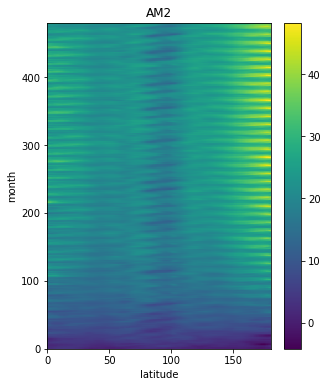

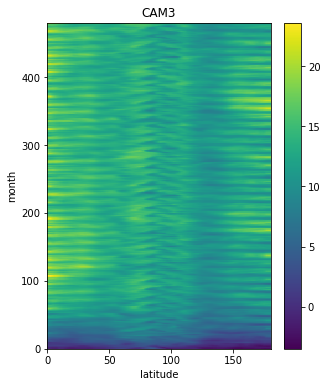

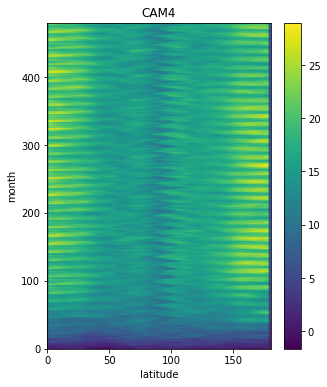

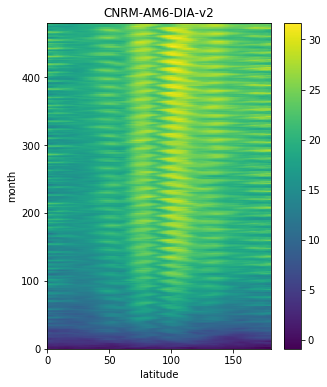

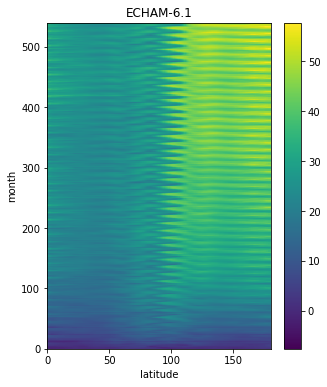

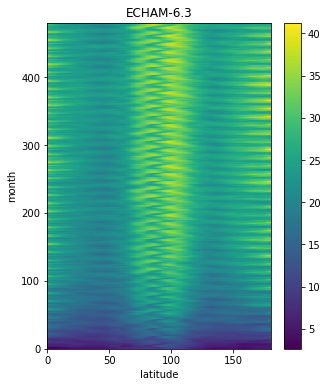

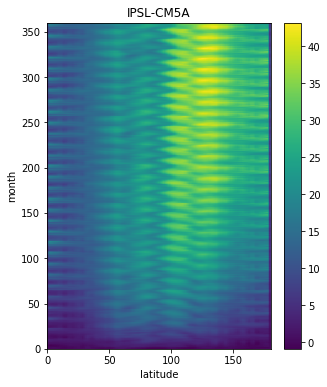

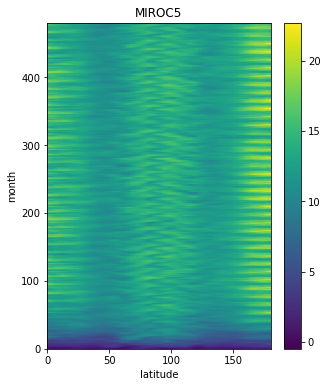

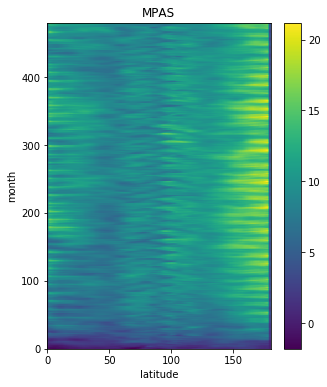

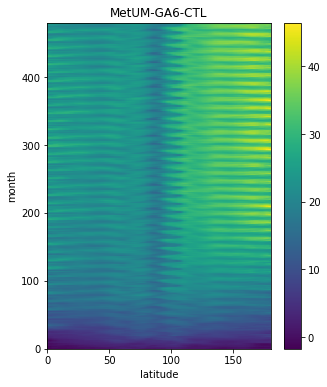

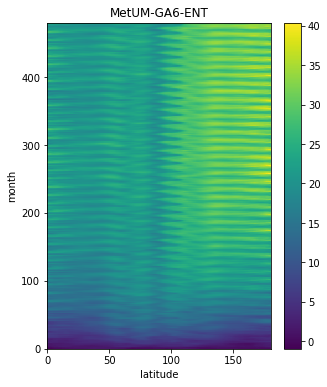

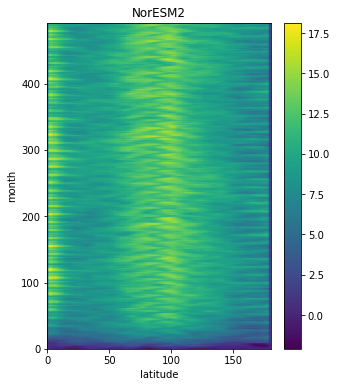

In [18]:
#Run the Gregory regressions on the Planck kernel results
return_dict_dLW_pl = dict()
for model in models_12:
    print(model)
    return_dict_dLW_pl[model] = GregoryKernel(zm_ts[model], zm_ts_clim[model], zm_dLW_pl[model])

In [19]:
#Concatenate results and save to NetCDF
ds_Gregory_dLW_pl = xr.concat(return_dict_dLW_pl.values(), dim=pd.Index(models_12))
ds_Gregory_dLW_pl = ds_Gregory_dLW_pl.rename({'concat_dim': 'model'})
ds_Gregory_dLW_pl.to_netcdf('nc_from_xarray/Gregory_kernel_pl_a4.nc')

In [20]:
#OK, done. Next look at adjustment/feedback in "AnalyzeGregoryFeedbacks_v2". 